In [70]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline



In [71]:
class KNearestNeighbor(object):
    def __init__(self):
        pass
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distances(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dists, k=k)


    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train)) 
        dists = np.sqrt(np.sum(np.square(self.X_train), axis=1) + np.sum(np.square(X), axis=1)[:, np.newaxis] - 2 * np.dot(X, self.X_train.T))
        pass
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            sorted_dist = np.argsort(dists[i])
            closest_y = list(self.y_train[sorted_dist[0:k]])
            pass
            y_pred[i]= (np.argmax(np.bincount(closest_y)))
            pass
        return y_pred



# 加载数据集

In [72]:
import os
import sys
import urllib.request
import tarfile
import pickle
import numpy as np
import platform

# 下载并解压数据集
def maybe_download_and_extract(url, download_dir):
    """
    下载并解压 CIFAR-10 数据集（若不存在）。
    :param url: 数据集下载地址
    :param download_dir: 下载存储目录
    """
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    if not os.path.exists(file_path):
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # 下载文件并显示进度
        def _print_download_progress(count, block_size, total_size):
            pct_complete = float(count * block_size) / total_size
            msg = "\r- Download progress: {0:.1%}".format(pct_complete)
            sys.stdout.write(msg)
            sys.stdout.flush()

        urllib.request.urlretrieve(url=url, filename=file_path, reporthook=_print_download_progress)
        print("\nDownload finished. Extracting files.")

        # 解压文件
        if file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)
        print("Extraction complete.")
    else:
        print("Data already downloaded and unpacked.")

# 加载单个批次的 CIFAR 数据
def load_CIFAR_batch(filename):
    """
    加载单个 CIFAR 批次文件。
    :param filename: 文件路径
    :return: 图片和标签数组
    """
    with open(filename, 'rb') as f:
        version = platform.python_version_tuple()
        datadict = pickle.load(f) if version[0] == '2' else pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

# 加载所有 CIFAR-10 数据
def load_CIFAR10(root):
    """
    加载整个 CIFAR-10 数据集。
    :param root: 数据集文件目录
    :return: 训练图片、训练标签，测试图片、测试标签
    """
    xs, ys = [], []
    for b in range(1, 6):
        f = os.path.join(root, f'data_batch_{b}')
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    X_train = np.concatenate(xs)
    y_train = np.concatenate(ys)
    X_test, y_test = load_CIFAR_batch(os.path.join(root, 'test_batch'))
    return X_train, y_train, X_test, y_test

# 下载 CIFAR-10 数据集
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "./data"
maybe_download_and_extract(url, download_dir)

# 加载数据集
cifar10_dir = './data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 检查数据形状
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Data already downloaded and unpacked.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


# 可视化数据集

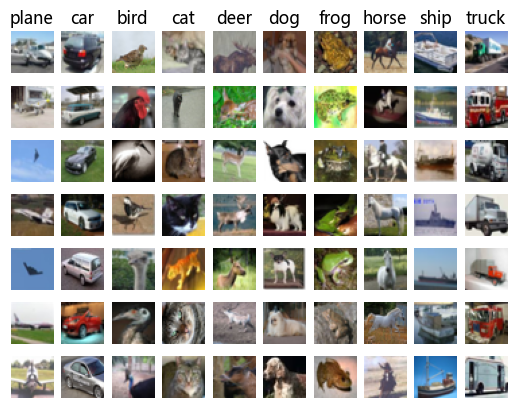

In [73]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# 数据降采样

In [74]:
# 通过对子集数据进行采样来限制数据规模

num_training = 10000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 1000
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [75]:
# reshaping data and placing into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)


(10000, 3072) (1000, 3072)


# 交叉验证

5折交叉验证

In [76]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)
k_to_accuracies = {}

# 记录最佳准确率和对应的k值
best_k = None
best_accuracy = 0

for k in k_choices:
    k_to_accuracies[k] = []
    for num_knn in range(0,num_folds):
        X_test = X_train_folds[num_knn]
        y_test = y_train_folds[num_knn]
        X_train = X_train_folds
        y_train = y_train_folds
        
        temp = np.delete(X_train,num_knn,0)
        X_train = np.concatenate((temp),axis = 0)
        y_train = np.delete(y_train,num_knn,0)
        y_train = np.concatenate((y_train),axis = 0)
        
        classifier = KNearestNeighbor()
        classifier.train(X_train, y_train)
        dists = classifier.compute_distances(X_test)
        y_test_pred = classifier.predict_labels(dists, k)

        num_correct = np.sum(y_test_pred == y_test)
        accuracy = float(num_correct) / num_test
#         print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
        k_to_accuracies[k].append(accuracy)
        # 更新最佳k值
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = k

print("Printing our 5-fold accuracies for varying values of k:")
print()
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

# 打印最佳的k值
print("\nThe best k is: %d with accuracy: %.2f%%" % (best_k, best_accuracy * 100))

Printing our 5-fold accuracies for varying values of k:

k = 1, accuracy = 0.577000
k = 1, accuracy = 0.568000
k = 1, accuracy = 0.565000
k = 1, accuracy = 0.549000
k = 1, accuracy = 0.554000
k = 3, accuracy = 0.575000
k = 3, accuracy = 0.548000
k = 3, accuracy = 0.557000
k = 3, accuracy = 0.535000
k = 3, accuracy = 0.531000
k = 5, accuracy = 0.589000
k = 5, accuracy = 0.568000
k = 5, accuracy = 0.595000
k = 5, accuracy = 0.550000
k = 5, accuracy = 0.557000
k = 8, accuracy = 0.597000
k = 8, accuracy = 0.592000
k = 8, accuracy = 0.568000
k = 8, accuracy = 0.548000
k = 8, accuracy = 0.572000
k = 10, accuracy = 0.605000
k = 10, accuracy = 0.574000
k = 10, accuracy = 0.568000
k = 10, accuracy = 0.532000
k = 10, accuracy = 0.570000
k = 12, accuracy = 0.609000
k = 12, accuracy = 0.587000
k = 12, accuracy = 0.571000
k = 12, accuracy = 0.530000
k = 12, accuracy = 0.551000
k = 15, accuracy = 0.588000
k = 15, accuracy = 0.594000
k = 15, accuracy = 0.550000
k = 15, accuracy = 0.548000
k = 15, acc

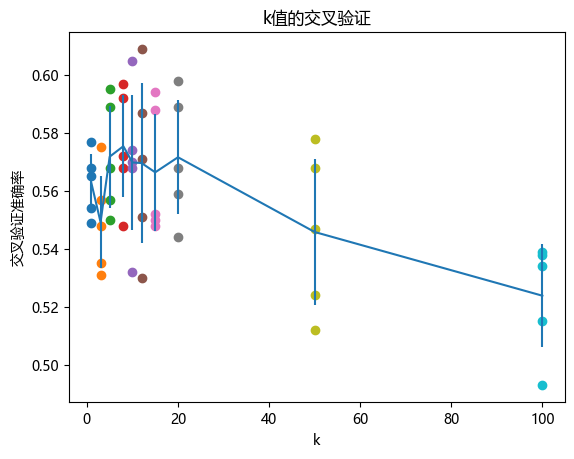

In [77]:
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')
from numpy import square
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('k值的交叉验证')
plt.xlabel('k')
plt.ylabel('交叉验证准确率')
plt.show()

In [78]:
# 基于交叉验证结果选择最佳的k值
best_k = 12 #选择的最佳k值是12

# 使用最佳k值训练KNN分类器
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)  # 在训练集上训练模型
y_test_pred = classifier.predict(X_test, k=best_k)  # 使用最佳k值进行预测

# 计算并显示使用最佳k值的准确率
num_correct = np.sum(y_test_pred == y_test)  # 计算预测正确的数量
accuracy = float(num_correct) / num_test  # 计算准确率
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))  # 输出准确率


Got 551 / 1000 correct => accuracy: 0.551000
